In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

%matplotlib inline
%pylab inline

import numpy as np                               # vectors and matrices
import pandas as pd
import datetime
import matplotlib.pylab as plt
import seaborn as sns
import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from matplotlib.pylab import style
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.api import qqplot
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox 
from sklearn.metrics import mean_squared_error
from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

style.use('ggplot')
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

Populating the interactive namespace from numpy and matplotlib


In [2]:
StockFile = 'JNJ_after.csv'
stock = pd.read_csv(StockFile, index_col = 0, parse_dates = [0])
stock.head(10)

,close
date,
2020-03-16,127.13
2020-03-17,136.59
2020-03-18,134.96
2020-03-19,127.05
2020-03-20,119.89
2020-03-23,111.14
2020-03-24,119.18
2020-03-25,119.40
2020-03-26,126.57


In [3]:
# Resample
stock_week = stock['close'].resample('W-MON').mean()
train_index = int(len(stock_week)*2/3)
stock_train = stock_week[0:train_index]
stock_train.tail(1)

date
2021-03-22    160.63
Freq: W-MON, Name: close, dtype: float64

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


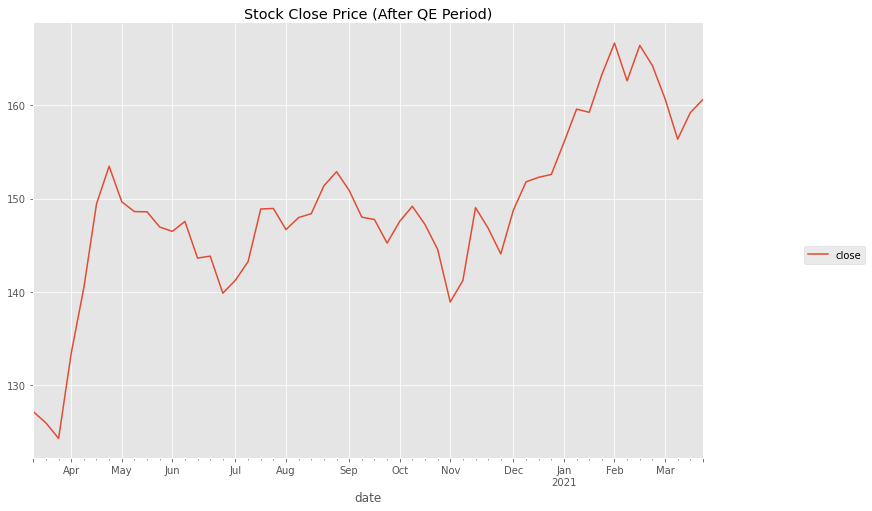

In [4]:
stock_train.plot(figsize=(12, 8))
plt.legend(bbox_to_anchor=(1.25, 0.5))
plt.title('Stock Close Price (After QE Period)')
sns.despine()
plt.show()

In [5]:
print(u'ADF Test result is:', ADF(stock_train))

ADF Test result is: (-2.205933650263367, 0.20409893716793864, 0, 53, {'1%': -3.560242358792829, '5%': -2.9178502070837, '10%': -2.5967964150943397}, 215.94951352418133)


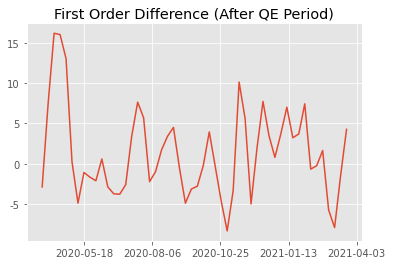

In [6]:
stock_diff = stock_train.diff(2)
stock_diff = stock_diff.dropna()

fig, ax = plt.subplots()
plt.plot(stock_diff)
plt.title('First Order Difference (After QE Period)')
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.show()

In [7]:
print(u'ADF Test result is:', ADF(stock_diff))

ADF Test result is: (-3.2676337375916256, 0.01638870928196008, 7, 44, {'1%': -3.5885733964124715, '5%': -2.929885661157025, '10%': -2.6031845661157025}, 215.02878743225662)


In [8]:
print(u'White Noise test result is：', acorr_ljungbox(stock_diff, lags=1))

White Noise test result is： (array([16.49902887]), array([4.86749988e-05]))


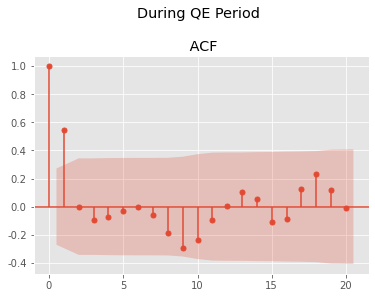

In [9]:
acf = plot_acf(stock_diff, lags = 20)
plt.title('During QE Period \n \n ACF')
acf.show()

<bound method Figure.show of <Figure size 432x288 with 1 Axes>>

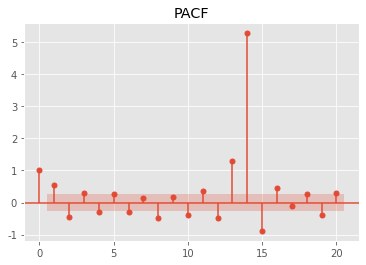

In [10]:
pacf = plot_pacf(stock_diff, lags = 20)
plt.title('PACF')
pacf.show

In [11]:
arma_mod20 = sm.tsa.ARIMA(stock["close"],(1,1,0)).fit()
arma_mod30 = sm.tsa.ARIMA(stock["close"],(0,1,1)).fit()
arma_mod40 = sm.tsa.ARIMA(stock["close"],(1,1,1)).fit()
values = [[arma_mod20.aic,arma_mod20.bic,arma_mod20.hqic],[arma_mod30.aic,arma_mod30.bic,arma_mod30.hqic],[arma_mod40.aic,arma_mod40.bic,arma_mod40.hqic]]
df = pd.DataFrame(values,index=["AR(1,1,0)","MA(0,1,1)","ARMA(1,1,1)"],columns=["AIC","BIC","hqic"])
df

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no ass

,AIC,BIC,hqic
"AR(1,1,0)",1654.297470,1666.203593,1659.016653
"MA(0,1,1)",1654.502941,1666.409064,1659.222124
"ARMA(1,1,1)",1653.151681,1669.026511,1659.443924


In [12]:
model_1 = ARIMA(stock_train, order = (1, 1, 0), freq = 'W-MON')
result = model_1.fit()

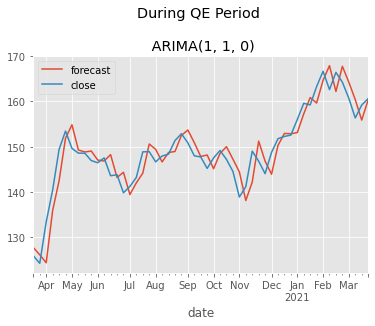

In [13]:
result.plot_predict(start = 1, end = 53)
plt.title("During QE Period \n \n ARIMA(1, 1, 0)")
plt.show()

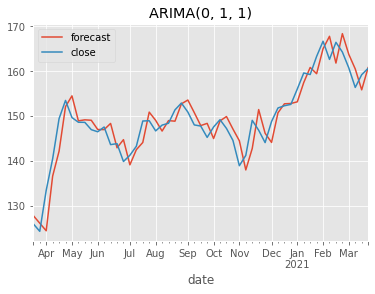

In [14]:
model_011 = ARIMA(stock_train, order = (0, 1, 1), freq = 'W-MON')
result_011 = model_011.fit()
result_011.plot_predict(start = 1, end = 53)
plt.title("ARIMA(0, 1, 1)")
plt.show()

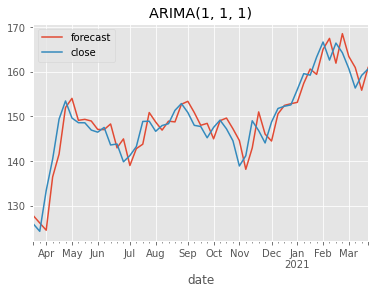

In [15]:
model_111 = ARIMA(stock_train, order = (1, 1, 1), freq = 'W-MON')
result_111 = model_111.fit()
result_111.plot_predict(start = 1, end = 53)
plt.title("ARIMA(1, 1, 1)")
plt.show()

In [16]:
print("During QE Period")
print(result.summary())

During QE Period
                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                   53
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -139.452
Method:                       css-mle   S.D. of innovations              3.359
Date:                Thu, 04 Nov 2021   AIC                            284.905
Time:                        15:33:10   BIC                            290.815
Sample:                    03-23-2020   HQIC                           287.178
                         - 03-22-2021                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.6265      0.590      1.062      0.288      -0.530       1.783
ar.L1.D.close     0.2220      0.133      1.671      0.095      -0.038       0.482
                       

Text(0.5, 1.0, 'During QE Period')

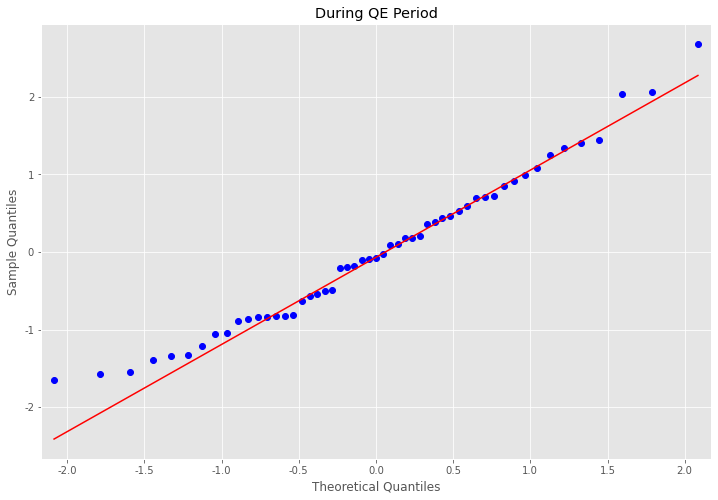

In [17]:
resid = result.resid
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(resid, line='q', ax=ax, fit=True)
plt.title("During QE Period")

In [18]:
print(acorr_ljungbox(resid)[1])

[0.78096317 0.53453101 0.72629069 0.83358626 0.91171027 0.95070414
 0.97716603 0.98494771 0.92729861 0.86409941 0.89156525 0.89450218
 0.83571278 0.87120092 0.86597878 0.86772122 0.89151669 0.76344932
 0.80759698 0.84123391 0.87861279 0.88055258 0.90617021 0.91404841]


In [19]:
pred = result.predict('2021-03-23', '2023',dynamic=True, typ='levels')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


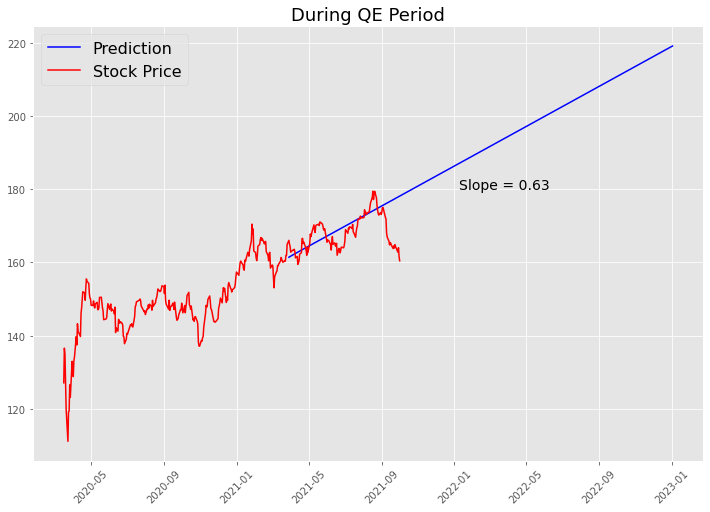

In [20]:
plt.figure(figsize=(12, 8))
plt.xticks(rotation=45)
plt.plot(pred, "-b", label="Prediction")
plt.plot(stock.close, "-r", label="Stock Price")
text(19000, 180, "Slope = 0.63", fontsize=14)
plt.legend(loc="upper left", fontsize=16)
plt.title('During QE Period', fontsize=18)
plt.show()

In [21]:
test_index = int(len(stock_week)*2/3)
stock_test = stock_week[test_index:]
test_pred = pred[0:int(len(stock_week)*1/3+1)]
print("MSE: ", mean_squared_error(stock_test, test_pred))

MSE:  30.24449247086776
